In [1]:
import h5py
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os

from neuropacks import PVC11
from uoineuro.coupling_utils import create_symmetrized_graph
from uoineuro.utils import plot_metric_summary, plot_difference_distribution

%matplotlib inline

In [2]:
monkeys = ['monkey1', 'monkey2', 'monkey3']
n_monkeys = len(monkeys)

In [3]:
results_paths = [os.path.join(os.environ['HOME'],
                              'fits/uoineuro/coupling/pvc11/pvc11_' + monkey + '_coupling.h5')
                 for monkey in monkeys]

In [4]:
fits = [h5py.File(results_paths[idx], 'r')
        for idx in range(n_monkeys)]

# Metric Comparison: Poisson Model

## Scatter Plots

In [5]:
baselines = [fits[idx]['glmnet_poisson'] for idx in range(n_monkeys)]
algorithms = [[fits[idx]['uoi_poisson_log'], fits[idx]['uoi_poisson_aic'], fits[idx]['uoi_poisson_bic']]
              for idx in range(n_monkeys)]

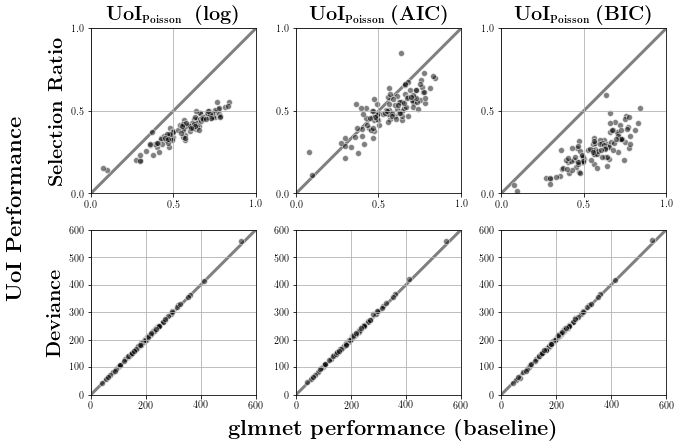

In [6]:
fig, axes = plot_metric_summary(baseline_group=baselines[0],
                                fits_groups=algorithms[0],
                                metrics=['selection_ratio', 'deviances_test'])

# additional customizations

# first row: selection ratio
for idx in range(3):
    ax = axes[0, idx]
    ax.set_xlim([0, 1])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(),
            color='gray', 
            linewidth=3,
            zorder=-1)
    ax.set_aspect('equal')
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 0.5, 1])
    ax.grid('on')

# second row: r2
for idx in range(3):
    ax = axes[1, idx]
    ax.set_xlim([0, 600])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(),
            color='gray', 
            linewidth=3,
            zorder=-1)
    ax.set_aspect('equal')
    ax.grid('on')

for ax in axes.ravel():
    ax.tick_params(labelsize=10)

axes[0, 0].set_ylabel(r'\textbf{Selection Ratio}', fontsize=20)
axes[1, 0].set_ylabel(r'\textbf{Deviance}', fontsize=20)


axes[0, 0].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Poisson}}$ \textbf{ (log)}',
                     fontsize=20)
axes[0, 1].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Poisson}}$ \textbf{(AIC)}',
                     fontsize=20)
axes[0, 2].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Poisson}}$ \textbf{(BIC)}',
                     fontsize=20)

fig.text(
    x=0.55, y=-0.01,
    s=r'\textbf{glmnet performance (baseline)}',
    fontsize=22,
    horizontalalignment='center',
    verticalalignment='center')

fig.text(
    x=-0.03, y=0.5,
    s=r'\textbf{UoI Performance}',
    fontsize=22,
    rotation=90,
    horizontalalignment='center',
    verticalalignment='center')

plt.tight_layout()
# plt.savefig('pvc11_monkey1_coupling_poisson_metric_summary.pdf', bbox_inches='tight')

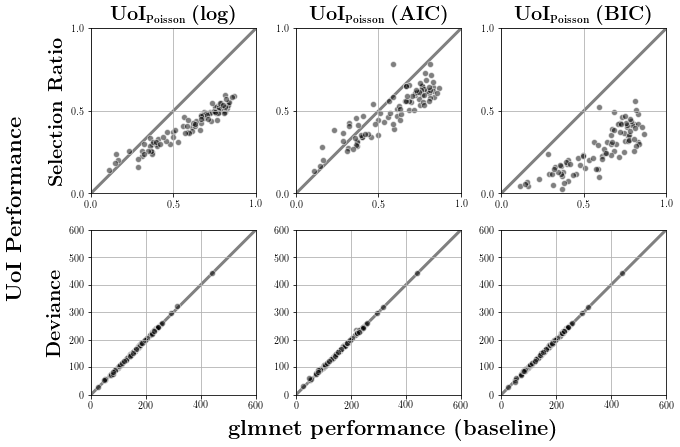

In [7]:
fig, axes = plot_metric_summary(baseline_group=baselines[1],
                                fits_groups=algorithms[1],
                                metrics=['selection_ratio', 'deviances_test'])

# additional customizations

# first row: selection ratio
for idx in range(3):
    ax = axes[0, idx]
    ax.set_xlim([0, 1])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(),
            color='gray', 
            linewidth=3,
            zorder=-1)
    ax.set_aspect('equal')
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 0.5, 1])
    ax.grid('on')

# second row: r2
for idx in range(3):
    ax = axes[1, idx]
    ax.set_xlim([0, 600])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(),
            color='gray', 
            linewidth=3,
            zorder=-1)
    ax.set_aspect('equal')
    ax.grid('on')

for ax in axes.ravel():
    ax.tick_params(labelsize=10)

axes[0, 0].set_ylabel(r'\textbf{Selection Ratio}', fontsize=20)
axes[1, 0].set_ylabel(r'\textbf{Deviance}', fontsize=20)


axes[0, 0].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Poisson}}$ \textbf{(log)}',
                     fontsize=20)
axes[0, 1].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Poisson}}$ \textbf{(AIC)}',
                     fontsize=20)
axes[0, 2].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Poisson}}$ \textbf{(BIC)}',
                     fontsize=20)

fig.text(
    x=0.55, y=-0.01,
    s=r'\textbf{glmnet performance (baseline)}',
    fontsize=22,
    horizontalalignment='center',
    verticalalignment='center')

fig.text(
    x=-0.03, y=0.5,
    s=r'\textbf{UoI Performance}',
    fontsize=22,
    rotation=90,
    horizontalalignment='center',
    verticalalignment='center')

plt.tight_layout()
# plt.savefig('pvc11_monkey2_coupling_poisson_metric_summary.pdf', bbox_inches='tight')

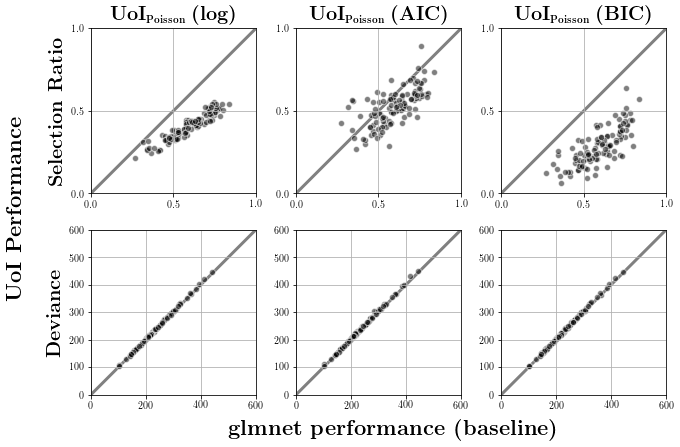

In [8]:
fig, axes = plot_metric_summary(baseline_group=baselines[2],
                                fits_groups=algorithms[2],
                                metrics=['selection_ratio', 'deviances_test'])

# additional customizations #

# first row: selection ratio
for idx in range(3):
    ax = axes[0, idx]
    ax.set_xlim([0, 1])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(),
            color='gray', 
            linewidth=3,
            zorder=-1)
    ax.set_aspect('equal')
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 0.5, 1])
    ax.grid('on')

# second row: r2
for idx in range(3):
    ax = axes[1, idx]
    ax.set_xlim([0, 600])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(),
            color='gray', 
            linewidth=3,
            zorder=-1)
    ax.set_aspect('equal')
    ax.grid('on')

for ax in axes.ravel():
    ax.tick_params(labelsize=10)

axes[0, 0].set_ylabel(r'\textbf{Selection Ratio}', fontsize=20)
axes[1, 0].set_ylabel(r'\textbf{Deviance}', fontsize=20)


axes[0, 0].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Poisson}}$ \textbf{(log)}',
                     fontsize=20)
axes[0, 1].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Poisson}}$ \textbf{(AIC)}',
                     fontsize=20)
axes[0, 2].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Poisson}}$ \textbf{(BIC)}',
                     fontsize=20)

fig.text(
    x=0.55, y=-0.01,
    s=r'\textbf{glmnet performance (baseline)}',
    fontsize=22,
    horizontalalignment='center',
    verticalalignment='center')

fig.text(
    x=-0.03, y=0.5,
    s=r'\textbf{UoI Performance}',
    fontsize=22,
    rotation=90,
    horizontalalignment='center',
    verticalalignment='center')

plt.tight_layout()
#plt.savefig('pvc11_monkey3_coupling_poisson_metric_summary.pdf', bbox_inches='tight')

## Difference Distributions

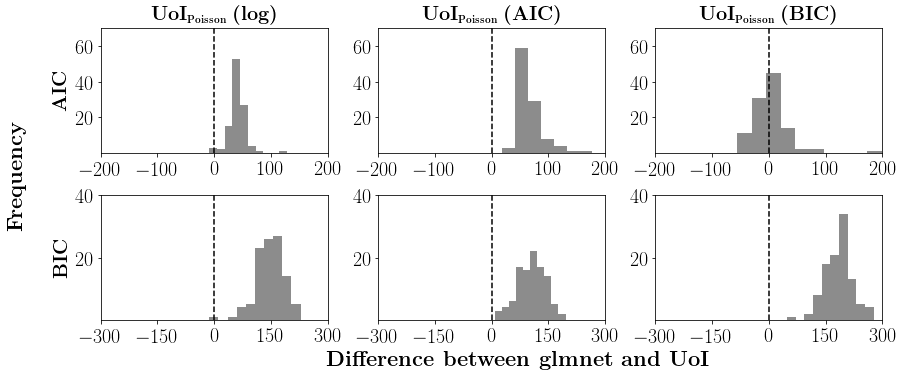

In [10]:
fig, axes = plot_difference_distribution(baseline_group=baselines[0],
                                fits_groups=algorithms[0],
                                metrics=['aics', 'bics'])

for ax in axes[0]:
    ax.set_xlim([-200, 200])
    ax.axvline(0, linestyle='--', color='k')
    ax.set_ylim([0, 70])
    ax.set_xticks([-200, -100, 0, 100, 200])
    ax.set_yticks([20, 40, 60])
    
for ax in axes[1]:
    ax.set_xlim([-300, 300])
    ax.axvline(0, linestyle='--', color='k')
    ax.set_ylim([0, 40])
    ax.set_xticks([-300, -150, 0, 150, 300])
    ax.set_yticks([20, 40])
    
axes[0, 0].set_ylabel(r'\textbf{AIC}', fontsize=20)
axes[1, 0].set_ylabel(r'\textbf{BIC}', fontsize=20)


axes[0, 0].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Poisson}}$ \textbf{(log)}',
                     fontsize=20)
axes[0, 1].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Poisson}}$ \textbf{(AIC)}',
                     fontsize=20)
axes[0, 2].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Poisson}}$ \textbf{(BIC)}',
                     fontsize=20)

fig.text(
    x=0.55, y=-0.01,
    s=r'\textbf{Difference between glmnet and UoI}',
    fontsize=22,
    horizontalalignment='center',
    verticalalignment='center')

fig.text(
    x=-0.03, y=0.5,
    s=r'\textbf{Frequency}',
    fontsize=22,
    rotation=90,
    horizontalalignment='center',
    verticalalignment='center')

plt.tight_layout()
# plt.savefig('pvc11_monkey1_coupling_poisson_difference_distributions.pdf', bbox_inches='tight')

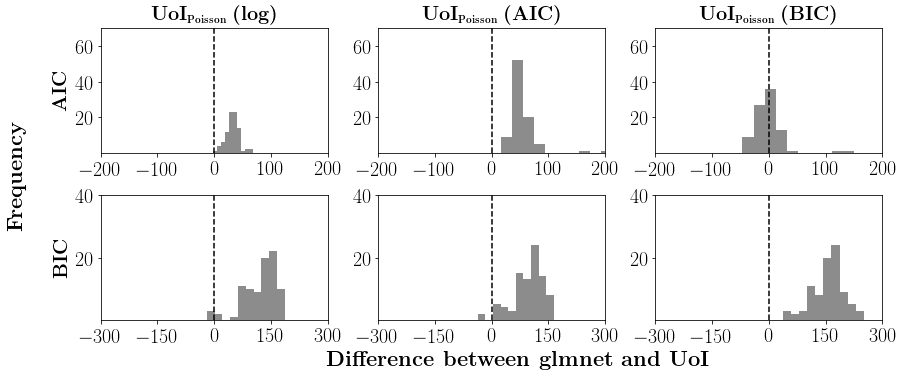

In [12]:
fig, axes = plot_difference_distribution(baseline_group=baselines[1],
                                fits_groups=algorithms[1],
                                metrics=['aics', 'bics'])

for ax in axes[0]:
    ax.set_xlim([-200, 200])
    ax.axvline(0, linestyle='--', color='k')
    ax.set_ylim([0, 70])
    ax.set_xticks([-200, -100, 0, 100, 200])
    ax.set_yticks([20, 40, 60])
    
for ax in axes[1]:
    ax.set_xlim([-300, 300])
    ax.axvline(0, linestyle='--', color='k')
    ax.set_ylim([0, 40])
    ax.set_xticks([-300, -150, 0, 150, 300])
    ax.set_yticks([20, 40])
    
axes[0, 0].set_ylabel(r'\textbf{AIC}', fontsize=20)
axes[1, 0].set_ylabel(r'\textbf{BIC}', fontsize=20)


axes[0, 0].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Poisson}}$ \textbf{(log)}',
                     fontsize=20)
axes[0, 1].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Poisson}}$ \textbf{(AIC)}',
                     fontsize=20)
axes[0, 2].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Poisson}}$ \textbf{(BIC)}',
                     fontsize=20)

fig.text(
    x=0.55, y=-0.01,
    s=r'\textbf{Difference between glmnet and UoI}',
    fontsize=22,
    horizontalalignment='center',
    verticalalignment='center')

fig.text(
    x=-0.03, y=0.5,
    s=r'\textbf{Frequency}',
    fontsize=22,
    rotation=90,
    horizontalalignment='center',
    verticalalignment='center')

plt.tight_layout()
# plt.savefig('pvc11_monkey2_coupling_poisson_difference_distributions.pdf', bbox_inches='tight')

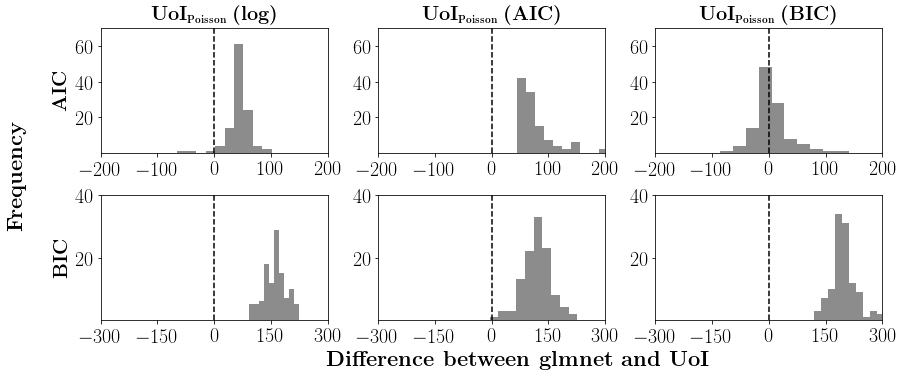

In [13]:
fig, axes = plot_difference_distribution(baseline_group=baselines[2],
                                fits_groups=algorithms[2],
                                metrics=['aics', 'bics'])

for ax in axes[0]:
    ax.set_xlim([-200, 200])
    ax.axvline(0, linestyle='--', color='k')
    ax.set_ylim([0, 70])
    ax.set_xticks([-200, -100, 0, 100, 200])
    ax.set_yticks([20, 40, 60])
    
for ax in axes[1]:
    ax.set_xlim([-300, 300])
    ax.axvline(0, linestyle='--', color='k')
    ax.set_ylim([0, 40])
    ax.set_xticks([-300, -150, 0, 150, 300])
    ax.set_yticks([20, 40])
    
axes[0, 0].set_ylabel(r'\textbf{AIC}', fontsize=20)
axes[1, 0].set_ylabel(r'\textbf{BIC}', fontsize=20)


axes[0, 0].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Poisson}}$ \textbf{(log)}',
                     fontsize=20)
axes[0, 1].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Poisson}}$ \textbf{(AIC)}',
                     fontsize=20)
axes[0, 2].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Poisson}}$ \textbf{(BIC)}',
                     fontsize=20)

fig.text(
    x=0.55, y=-0.01,
    s=r'\textbf{Difference between glmnet and UoI}',
    fontsize=22,
    horizontalalignment='center',
    verticalalignment='center')

fig.text(
    x=-0.03, y=0.5,
    s=r'\textbf{Frequency}',
    fontsize=22,
    rotation=90,
    horizontalalignment='center',
    verticalalignment='center')

plt.tight_layout()
# plt.savefig('pvc11_monkey3_coupling_poisson_difference_distributions.pdf', bbox_inches='tight')

# Connectivity Plots

In [5]:
baselines = [fits[idx]['glmnet_poisson'] for idx in range(n_monkeys)]
algorithms = [[fits[idx]['uoi_poisson_log'], fits[idx]['uoi_poisson_aic'], fits[idx]['uoi_poisson_bic']]
              for idx in range(n_monkeys)]

In [6]:
data_path = os.path.join('/storage/data/pvc11/data/spikes_gratings/data_monkey1_gratings.mat')

In [7]:
data_path = os.path.join(os.environ['HOME'],
                         'data/pvc11/data/spikes_gratings/data_monkey1_gratings.mat')

In [8]:
pvc11 = PVC11(data_path=data_path)

In [9]:
glmnet_median_coefs = np.median(baselines[0]['coupling_coefs'], axis=0)
uoi_median_coefs = np.median(algorithms[0][2]['coupling_coefs'], axis=0)

In [13]:
G_glmnet, weights_glmnet = create_symmetrized_graph(coupling_coefs=glmnet_median_coefs)
G_uoi, weights_uoi = create_symmetrized_graph(coupling_coefs=uoi_median_coefs)

In [18]:
nx.write_graphml(G_uoi, 'g_uoi.graphml')

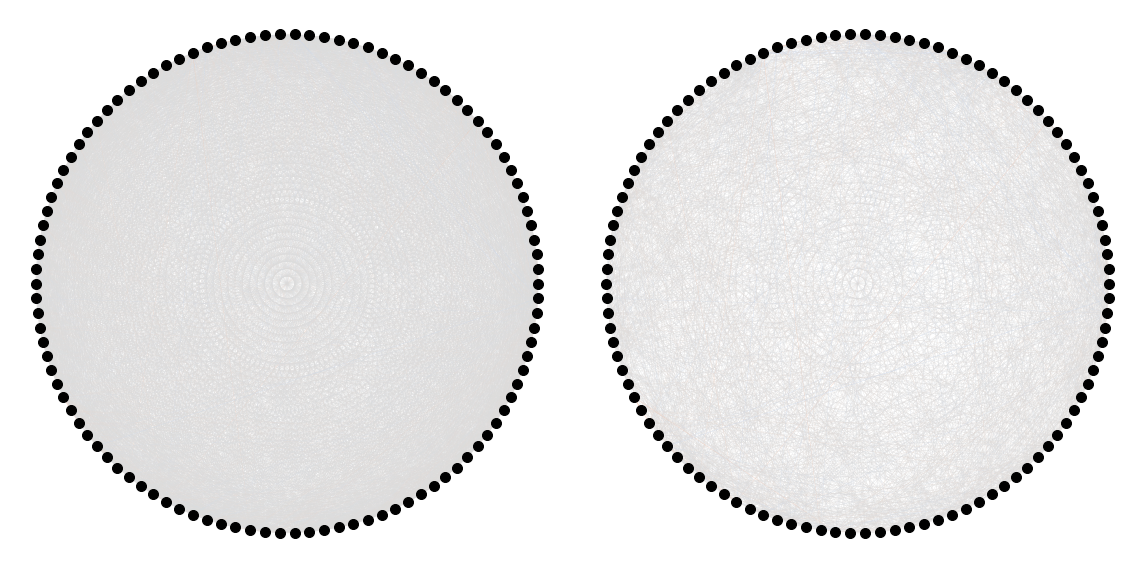

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

nx.draw_circular(
    G_glmnet,
    node_size=100,
    node_color='k',
    width=0.25 + np.abs(list(weights_glmnet.values()))**2,
    edge_color=list(weights_glmnet.values()),
    edge_cmap=plt.get_cmap('coolwarm'),
    edge_vmin=-0.4,
    edge_vmax=0.4,
    ax=axes[0])

nx.draw_circular(
    G_uoi,
    node_size=100,
    node_color='k',
    width=0.25 + np.abs(list(weights_uoi.values()))**2,
    edge_color=list(weights_uoi.values()),
    edge_cmap=plt.get_cmap('coolwarm'),
    edge_vmin=-0.4,
    edge_vmax=0.4,
    ax=axes[1])

plt.tight_layout()
# plt.savefig('pvc11_connectivity_graph.pdf', bbox_inches='tight')

# Metric Comparison: Lasso

In [15]:
results_paths = [os.path.join(os.environ['HOME'],
                              'fits/uoineuro/coupling/pvc11/pvc11_' + monkey + '_coupling_lasso.h5')
                 for monkey in monkeys]

In [16]:
fits = [h5py.File(results_paths[idx], 'r')
        for idx in range(n_monkeys)]

In [17]:
baselines = [fits[idx]['lasso'] for idx in range(n_monkeys)]
algorithms = [[fits[idx]['uoi_lasso_r2'], fits[idx]['uoi_lasso_aic'], fits[idx]['uoi_lasso_bic']]
              for idx in range(n_monkeys)]

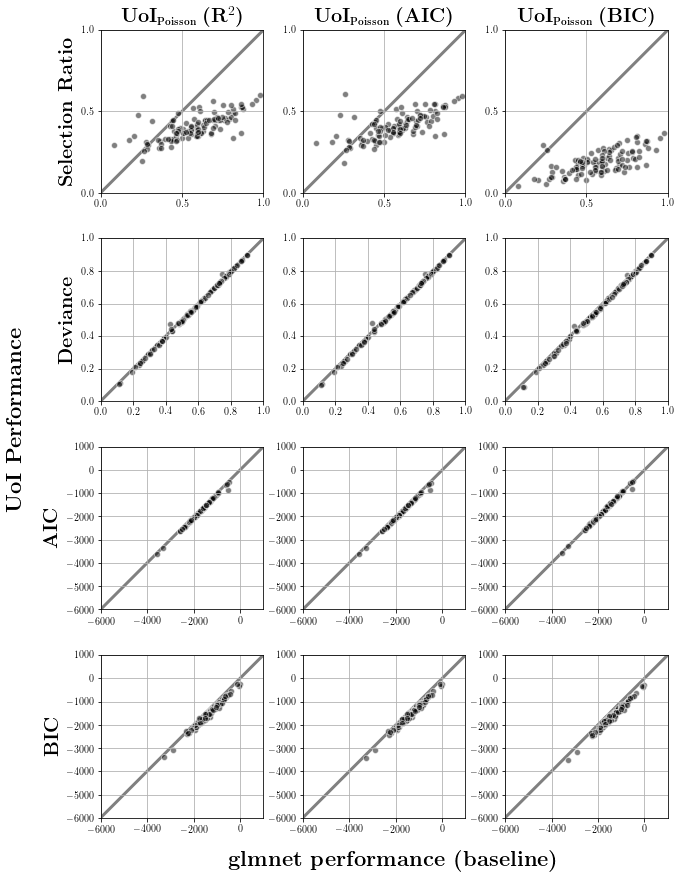

In [23]:
fig, axes = plot_metric_summary(baseline_group=baselines[2],
                               fits_groups=algorithms[2],
                               metrics=['selection_ratio', 'r2', 'AIC', 'BIC'])

# additional customizations

# first row: selection ratio
for idx in range(3):
    ax = axes[0, idx]
    ax.set_xlim([0, 1])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(),
            color='gray', 
            linewidth=3,
            zorder=-1)
    ax.set_aspect('equal')
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 0.5, 1])
    ax.grid('on')

# second row: r2
for idx in range(3):
    ax = axes[1, idx]
    ax.set_xlim([0, 1])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(),
            color='gray', 
            linewidth=3,
            zorder=-1)
    ax.set_aspect('equal')
    ax.grid('on')
    
    
# third row: AIC
for idx in range(3):
    ax = axes[2, idx]
    ax.set_xlim([-6000, 1000])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(),
            color='gray', 
            linewidth=3,
            zorder=-1)
    ax.set_aspect('equal')
    ax.grid('on')
    
# third row: BIC
for idx in range(3):
    ax = axes[3, idx]
    ax.set_xlim([-6000, 1000])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(),
            color='gray', 
            linewidth=3,
            zorder=-1)
    ax.set_aspect('equal')
    ax.grid('on')

for ax in axes.ravel():
    ax.tick_params(labelsize=10)

axes[0, 0].set_ylabel(r'\textbf{Selection Ratio}', fontsize=20)
axes[1, 0].set_ylabel(r'\textbf{Deviance}', fontsize=20)
axes[2, 0].set_ylabel(r'\textbf{AIC}', fontsize=20)
axes[3, 0].set_ylabel(r'\textbf{BIC}', fontsize=20)


axes[0, 0].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Poisson}}$ \textbf{(}$\mathbf{R}^2$\textbf{)}',
                     fontsize=20)
axes[0, 1].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Poisson}}$ \textbf{(AIC)}',
                     fontsize=20)
axes[0, 2].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Poisson}}$ \textbf{(BIC)}',
                     fontsize=20)

fig.text(
    x=0.55, y=-0.01,
    s=r'\textbf{glmnet performance (baseline)}',
    fontsize=22,
    horizontalalignment='center',
    verticalalignment='center')

fig.text(
    x=-0.03, y=0.5,
    s=r'\textbf{UoI Performance}',
    fontsize=22,
    rotation=90,
    horizontalalignment='center',
    verticalalignment='center')

plt.tight_layout()